# COVID-19 Prediction Model for Maryland

<B><U>Objective:</B></U> Predict the number of new COVID-19 cases for each Maryland County 14-days in the future.

<B><U>Data Sources:</B></U>
* COVID-19 Data:
    * COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. URL: https://github.com/CSSEGISandData/COVID-19.
* Vaccine Data:
    * COVID-19 Vaccinations in the United States, County. Centers for Disease Control and Prevention. URL: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh
* Travel Data:
  * Trips by Distance - Maryland Counties. Bureau of Transportation Statistics. URL: https://data.bts.gov/Research-and-Statistics/Trips-by-Distance-Maryland-Counties/k4y4-vf3n
  * Trips by Distance - All US. Bureau of Transportation Statistics URL: https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv
* US County Information:
    * USA Counties - Land Area. US Census Bureau. URL: https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html
* Weather data:
    * National Centers for Environmental Information - National Oceanic and Atmospheric Administration. URL: https://www.ncei.noaa.gov/access/search/data-search/global-hourly
    * Federal Climate Complex Data Documentation for Integrated Surface Data (ISD). URL: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf


## Part 1 - Exploratory Data Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from bokeh.models import NumeralTickFormatter, DatetimeTickFormatter, ColumnDataSource, HoverTool, CrosshairTool, SaveTool, PanTool, Range1d
from bokeh.plotting import figure, show, output_file
from bokeh.models import Line,TapTool
from bokeh.io import output_notebook, show
output_notebook()

import os

from multiprocessing import Pool

import seaborn as sns
from sklearn.ensemble import IsolationForest

Loading BokehJS ...

### Import Data

The below loads JHU's Covid-19 data using multiprocessing and corrects for inconsistent formatting across the CSV files.

In [2]:
# load data in parallel

def read_csv(file):
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    
    tmp = pd.read_csv(path + file)
    
    # the various try code blocks correct for inconsistencies between subsequent data files.
    try:
        tmp['Province_State']
    except KeyError:
        tmp = tmp.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region', 'Last Update': 'Last_Update'})
        tmp['Admin2'] = np.NaN
        tmp['FIPS'] = np.NaN
        tmp = tmp.astype({'Admin2': 'str', 'FIPS': 'float64'})
    
    try:
        tmp['Lat']
    except KeyError:
        tmp = tmp.rename(columns={'Latitude': 'Lat', 'Longitude': 'Long_'})
        
    try:
        tmp['Incidence_Rate']
    except KeyError:
        tmp = tmp.rename(columns={'Incident_Rate': 'Incidence_Rate'})
    
    try:
        tmp['Case-Fatality_Ratio']
    except KeyError:
        tmp = tmp.rename(columns={'Case_Fatality_Ratio': 'Case-Fatality_Ratio'})
    
    
    # Retain only those rows associated with the US
    tmp = tmp[tmp['Country_Region'] == 'US']
    
    # Extract the date from the filename
    file_date = file[-14:-4]
    
    # Date for EDA
    tmp['Data_Date'] = file_date
    tmp['Data_Date'] = pd.to_datetime(tmp['Data_Date'])
    
    # Date_Block field for easier sorting
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5])) # this adds the filename date as a new column
    
    return tmp


def parallel_load():

    granular_covid_data = pd.read_csv("COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/10-03-2020.csv")
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    files = os.listdir(path)
    file_list = [filename for filename in files if filename.split('.')[1]=='csv']

    with Pool(processes=4) as pool:

        df_list = pool.map(read_csv, file_list)

        granular_covid_data = pd.concat(df_list, ignore_index=True)
    
    return granular_covid_data

In [3]:
granular_covid_data = parallel_load()
granular_covid_data = granular_covid_data.sort_values(by = ['Province_State', 'FIPS', 'Date_Block'])

Import JHU's US Daily Data to merge testing rates into the <code>granular_covid_data</code> dataframe. This is not perfect, as testing data is measured at the State level. When applied to the county-level, this would proxy the county's contribution to overall state-level testing. The code also handles inconsistent column names across CSV files.

In [4]:
covid_data = pd.DataFrame()

path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports_us/*.csv"

for file in glob.glob(path):
    tmp = pd.read_csv(file)
    file_date = file[-14:-4] #this extracts the date from the filename
    
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5]))
    
    # handle different column names with the same testing data
    if 'People_Tested' in tmp.columns:
        tmp = tmp.rename(columns={"People_Tested": 'Total_Test_Results'})

    covid_data = pd.concat([covid_data,tmp])

covid_data = covid_data.sort_values(by = ['Province_State', 'Date_Block'])

covid_data = covid_data[['Province_State', 'Total_Test_Results', 'Date_Block']]

granular_covid_data = pd.merge(granular_covid_data, covid_data, on = ["Province_State", 'Date_Block'], how = 'left')

Import CDC's vaccination data. It is expected that new cases would be inversely correlated with vaccinations. 

In [5]:
vaxx_data = pd.read_csv("CDC/COVID-19_Vaccinations_in_the_United_States_County.csv")
vaxx_data = vaxx_data[['Date', 'FIPS', 'Series_Complete_Pop_Pct', 'Series_Complete_Yes', 'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct']]

vaxx_data['Date'] = pd.to_datetime(vaxx_data['Date'])
vaxx_data['Date_Block'] = vaxx_data['Date'].dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block
vaxx_data = vaxx_data[vaxx_data['FIPS'] != "UNK"] # drop rows where FIPS is unknown
vaxx_data['FIPS'] = vaxx_data['FIPS'].astype(int)
vaxx_data.drop(['Date'], axis = 1, inplace = True)

granular_covid_data = pd.merge(granular_covid_data, vaxx_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)

Import Census Bureau data on county land area. The idea is that the more concentrated people are in a county, more interactions between people occur causing the virus to spread.  

In [6]:
land_area = pd.read_excel("Census/LND01.xls")
land_area = land_area[['STCOU', 'LND110210D']]
land_area = land_area.rename(columns={"STCOU": 'FIPS', "LND110210D": 'Land_Area'})
granular_covid_data = pd.merge(granular_covid_data, land_area, on = ["FIPS"], how = 'left').fillna(0)

DOT's travel data could be used as a proxy for how frequently people interact. More trips and more people leaving their homes implies more interaction between people and therefore more opportunities for the virus to spread.

In [7]:
travel_data = pd.read_csv("DOT/Trips_by_Distance.csv")
travel_data['Date_Block'] = pd.to_datetime(travel_data['Date']).dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block

# keep only county-level data
travel_data = travel_data[travel_data['Level'] == 'County']
travel_data.drop(['Level', 'Date', 'State FIPS', 'State Postal Code', 'County Name', 'Row ID', 'Week', 'Month'], axis = 1, inplace = True)
travel_data = travel_data.rename(columns={'County FIPS': 'FIPS', 'Number of Trips <1': 'Number of Trips lt 1', 'Number of Trips >=500': 'Number of Trips gt 500'})
granular_covid_data = pd.merge(granular_covid_data, travel_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)

Import weather data for Dulles Airport. Unfortunately, I have not been able to locate weather data per county, so using Dulles for all counties isn't perfect. The rationale for adding weather data is the virus may spread more easily in certain environments (e.g. cooler weather). In addition, cooler weather suggests that people are spending more time indoors. Combined with travel data, it may imply more opportunities for the virus to spread.

In [8]:
weather_data = pd.read_csv("NOAA/Dulles_2020.csv")
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2021.csv")])
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2022.csv")])[['DATE', 'SOURCE', 'TMP', 'DEW', 'SLP']]  #Date, measurement source id, temperature, dewpoint, pressure 

/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (36,45,57,62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (42,43,44,54,59,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
weather_data.head(8)

,DATE,SOURCE,TMP,DEW,SLP
0,2020-01-01T00:00:00,4,"+0083,1","-0022,1","10061,1"
1,2020-01-01T00:52:00,7,"+0061,5","-0022,5","10064,5"
2,2020-01-01T01:52:00,7,"+0067,5","-0028,5","10071,5"
3,2020-01-01T02:52:00,7,"+0067,5","-0022,5","10073,5"
4,2020-01-01T03:52:00,7,"+0061,5","-0028,5","10074,5"
5,2020-01-01T04:52:00,7,"+0061,5","-0028,5","10074,5"
6,2020-01-01T04:59:00,6,"+9999,9","+9999,9","99999,9"
7,2020-01-01T04:59:00,6,"+9999,9","+9999,9","99999,9"


In [10]:
weather_data['Data_Date'] = pd.to_datetime(weather_data['DATE'])
weather_data['Date_Block'] = weather_data['Data_Date'].dt.strftime('%Y%m%d').astype(int)

# retain data from one weather station.
weather_data = weather_data[weather_data['SOURCE']==4]

# convert tmp, dew and slp from the encoded format to usable data
weather_data['Temperature'] = -9999
weather_data['Dew_Point'] = -9999
weather_data['Pressure'] = -9999

for i in range(len(weather_data)):
    weather_data.iloc[i,7] = int(weather_data.iloc[i,2][:-2])/10 #temperature
    weather_data.iloc[i,8] = int(weather_data.iloc[i,3][:-2])/10 #dew point
    weather_data.iloc[i,9] = int(weather_data.iloc[i,4][:-2])/10 #pressure

In [11]:
weather_data.describe()

,SOURCE,Date_Block,Temperature,Dew_Point,Pressure
count,3120.0,3.120000e+03,3120.000000,3120.000000,3120.000000
mean,4.0,2.020664e+07,13.464135,6.702660,1057.955160
std,0.0,6.028246e+03,9.936660,10.458536,600.476252
min,4.0,2.020010e+07,-11.700000,-17.800000,980.600000
25%,4.0,2.020072e+07,5.600000,-2.200000,1013.000000
50%,4.0,2.021013e+07,13.300000,7.200000,1017.400000
75%,4.0,2.021082e+07,22.200000,16.100000,1022.200000
max,4.0,2.022022e+07,36.100000,25.600000,9999.900000


In [12]:
# Drop rows with suspect pressure numbers
weather_data = weather_data[weather_data['Pressure'] < 2000] 

In [13]:
weather_data.describe()

,SOURCE,Date_Block,Temperature,Dew_Point,Pressure
count,3106.0,3.106000e+03,3106.000000,3106.000000,3106.000000
mean,4.0,2.020664e+07,13.482325,6.710753,1017.650193
std,0.0,6.031125e+03,9.950249,10.471718,7.184468
min,4.0,2.020010e+07,-11.700000,-17.800000,980.600000
25%,4.0,2.020072e+07,5.600000,-2.200000,1013.000000
50%,4.0,2.021013e+07,13.300000,7.200000,1017.400000
75%,4.0,2.021081e+07,22.200000,16.100000,1022.100000
max,4.0,2.022022e+07,36.100000,25.600000,1040.600000


In [14]:
weather_data = weather_data.drop(['DATE','SOURCE', 'TMP', 'DEW', 'SLP', 'Data_Date'], axis = 1)
weather_data = weather_data.groupby('Date_Block').mean()
weather_data = weather_data.reset_index()
weather_data

,Date_Block,Temperature,Dew_Point,Pressure
0,20200101,6.100,-3.175,1008.250
1,20200102,1.525,-5.575,1013.825
2,20200103,9.450,3.875,1010.325
3,20200104,11.425,10.425,1006.225
4,20200105,5.425,-1.375,1011.525
...,...,...,...,...
774,20220216,1.950,-6.675,1037.125
775,20220217,11.650,4.300,1024.275
776,20220218,14.175,4.300,1007.000
777,20220219,0.300,-9.025,1018.250


In [15]:
# merge weather data
granular_covid_data = pd.merge(granular_covid_data, weather_data, on = ['Date_Block'], how = 'left')

In [16]:
# calculate new cases
granular_covid_data['New_Cases'] = granular_covid_data['Confirmed'].diff(periods = 1).fillna(0).clip(lower = 0)

# calculate new tests
granular_covid_data['New_Tests'] = granular_covid_data['Total_Test_Results'].diff(periods = 1).fillna(0).clip(lower = 0)

### Examine imported data for anomalies

In [17]:
"""
Function for plotting a spaghetti chart of a particular metric of a particular State. 

The function takes four inputs: 
* state: state's data to be plotted (string), 
* counties: counties to be plotted (list of county names, or string 'all')
* metric: feature name to be plotted (string)
* text: title for the chart (string)
"""

def spaghetti_chart(state, counties, metric, text):
    
    try:
        assert state in granular_covid_data['Province_State'].unique()
    except AssertionError:
        raise AssertionError(state + " not in dataset.")
    
    if counties != 'all':
        try:
            for county in counties:
                assert county in granular_covid_data[(granular_covid_data['Country_Region'] == 'US') & (granular_covid_data['Province_State'] == state)]['Admin2'].unique()
        except AssertionError:
            raise AssertionError(county + " is not a county in " + state)
    
    try:
        assert metric in granular_covid_data.columns
    except AssertionError:
        raise AssertionError(metric + " is not a column in the dataset.")
    
    
    state_granular = granular_covid_data[(granular_covid_data['Country_Region'] == 'US') & (granular_covid_data['Province_State'] == state)]
    state_granular = state_granular.dropna(subset=['Date_Block','FIPS']).reset_index().drop(['index'], axis=1)
    
    state_df = pd.DataFrame(state_granular.sort_values(['Data_Date'])['Data_Date'].unique(), columns = ['Data_Date'])
    
    if counties == 'all':
        counties = state_granular['Admin2'].unique()

    for county in counties:
        tmp = state_granular[state_granular["Admin2"]==county][['Data_Date', metric]].reset_index().drop(['index'], axis=1)
        tmp = tmp.rename(columns={"Data_Date": "Data_Date", metric: county})
        state_df = pd.merge(state_df,tmp, on="Data_Date", how = 'left')

    source = ColumnDataSource(state_df)

    p = figure(plot_width=800, plot_height=400, tools="tap, wheel_zoom, save, pan, reset", title= state + " " + text, x_axis_type="datetime")
    renderer = p.line('Data_Date', counties[0], source = source, line_color = 'gray', line_width=2)

    hover = HoverTool(tooltips=[('date', '@Data_Date{%F}'), (metric, "$y{0,0}"), ("County", "$name")],
              formatters={'@Data_Date': 'datetime'})
    hover.point_policy='snap_to_data'
    hover.line_policy = "nearest"


    for county in counties:

        renderer = p.line('Data_Date', county, source = source, line_color = 'gray', line_width=2, name = county)

        selected_line = Line(line_color='red', line_width=4)
        nonselected_line = Line(line_color='gray')

        renderer.selection_glyph = selected_line
        renderer.nonselection_glyph = nonselected_line

    p.add_tools(hover)
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = text
    p.yaxis.formatter.use_scientific = False

    show(p)

In [18]:
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "Population Staying at Home", text = "Population Staying at Home") 

We can see that data does not appear to be reported on certain days during the latter part of 2021. For instance, Thanksgiving and New Years. Total Tests in December 2021 is flat for most days. This was due to the cyberattack MD Department of Health experienced. This data is not available and will need to be proxied.

In [19]:
spaghetti_chart(state = "Virginia", counties = ['Fairfax'], metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "Virginia", counties = ['Fairfax'], metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "Virginia", counties = ['Fairfax'], metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "Virginia", counties = ['Fairfax'], metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "Virginia", counties = ['Fairfax'], metric = "Population Staying at Home", text = "Population Staying at Home") 

It appears that approximately mid-July 2021, Virginia stopped reporting daily data. Specifically, Virginia stopped reporting data on the weekends and combined the weekend's numbers with the following business day's numbers. There is a spike in vaccinations in September 2021.

In [20]:
spaghetti_chart(state = "Pennsylvania", counties = ['Allegheny'], metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "Pennsylvania", counties = ['Allegheny'], metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "Pennsylvania", counties = ['Allegheny'], metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "Pennsylvania", counties = ['Allegheny'], metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "Pennsylvania", counties = ['Allegheny'], metric = "Population Staying at Home", text = "Population Staying at Home") 

Similar to Virginia, data appears not reported on weekends in certain instances. There's also an oddity with the vaccination data where the percent fully vaccinated spikes down, then spikes back up.

In [21]:
spaghetti_chart(state = "Pennsylvania", counties = ['Cameron'], metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "Pennsylvania", counties = ['Cameron'], metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "Pennsylvania", counties = ['Cameron'], metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "Pennsylvania", counties = ['Cameron'], metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "Pennsylvania", counties = ['Cameron'], metric = "Population Staying at Home", text = "Population Staying at Home") 

The data for a smaller Pennsylvania county has similar data availability issues like Allegheny county. Travel data has a sudden spike down in April 2021. It is possible that there were too few data points available on that day, so zero is reported to preserve anonymity. 

In [22]:
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "Population Staying at Home", text = "Population Staying at Home") 

DC has similar data availability concerns on weekends as other jurisdictions. Travel data has a drop in people staying home in mid-April 2021. 

In [23]:
spaghetti_chart(state = "Delaware", counties = 'all', metric = "New_Cases", text = "New Cases")
spaghetti_chart(state = "Delaware", counties = 'all', metric = "New_Tests", text = "New Tests")
spaghetti_chart(state = "Delaware", counties = 'all', metric = "Total_Test_Results", text = "Total Tests") 
spaghetti_chart(state = "Delaware", counties = 'all', metric = "Series_Complete_Pop_Pct", text = "Percentage of population fully vaccinated") 
spaghetti_chart(state = "Delaware", counties = 'all', metric = "Population Staying at Home", text = "Population Staying at Home") 

Delaware testing data has two spikes. Although new cases do drop to zero from time to time, the data appears to be correct. There isn't a consistent pattern of new cases falling to zero on weekends/holidays like other states. 

### Create basic features for examination

In [24]:
# Add population. We can back into the population for each county.
imputed_population = granular_covid_data[granular_covid_data['Date_Block'] == 20200529]
imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)

cols = ['Admin2', 'Province_State', 'Population']
tmp = imputed_population[cols]
granular_covid_data = pd.merge(granular_covid_data, tmp, on = ['Admin2', 'Province_State'], how = 'left')

granular_covid_data = granular_covid_data.dropna(subset=['Date_Block','FIPS', 'Population']).reset_index().drop(['index'], axis=1) #this is to drop the unclassified FIPS
granular_covid_data = granular_covid_data[granular_covid_data['Admin2'] != "Unassigned"] # drops unassigned counties (Delaware related)

<ipython-input-24-44671abfcfb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)


In [25]:
# Add test positivity rate. Not perfect as this calculates county-level new cases divided by state-wide new tests. 
# So this is like a contribution to the state's positivity rate.
granular_covid_data['Test_Positivity'] = (granular_covid_data['New_Cases'] / granular_covid_data['New_Tests'])

#some dates have no new tests but positive new cases. this will cause inf
granular_covid_data.replace([np.inf], np.nan, inplace = True)

# replace NaNs with 5 day exponential moving average
granular_covid_data['Test_Positivity'] = granular_covid_data.groupby(['FIPS'])['Test_Positivity'].fillna(granular_covid_data['Test_Positivity'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean()))

In [26]:
granular_covid_data['Infection_Rate_Per_Square_Mile'] = (granular_covid_data['New_Cases']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['One_Dose_Rate_Per_Square_Mile'] = (granular_covid_data['Administered_Dose1_Recip']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Full_Vaxx_Rate_Per_Square_Mile'] = (granular_covid_data['Series_Complete_Yes']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Test_Pos_Rate_Per_Square_Mile'] = (granular_covid_data['Test_Positivity']/granular_covid_data['Population'])/granular_covid_data['Land_Area']

In [27]:
granular_covid_data['Percent_People_Staying_Home'] = granular_covid_data['Population Staying at Home'] / (granular_covid_data['Population Staying at Home'] + granular_covid_data['Population Not Staying at Home'])

In [28]:
md_granular = granular_covid_data[(granular_covid_data['Province_State'] == 'Maryland') | (granular_covid_data['Province_State'] == 'Virginia') | (granular_covid_data['Province_State'] == 'District of Columbia')]
md_granular = md_granular.dropna(subset=['Date_Block','FIPS']).reset_index().drop(['index'], axis=1)

# generate target variable
md_granular['Cases_14_Days_Forward'] = md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])['New_Cases'].shift(-14).fillna(0)
md_granular['Cases_14_Days_Forward_Rate_Per_Square_Mile'] = (md_granular['Cases_14_Days_Forward']/md_granular['Population'])/md_granular['Land_Area']

In [29]:
df_pp = md_granular[md_granular['Province_State']=='District of Columbia'][['Province_State', 'Temperature', 'Dew_Point', 'Series_Complete_Pop_Pct', 'Test_Pos_Rate_Per_Square_Mile', 'Cases_14_Days_Forward_Rate_Per_Square_Mile']]

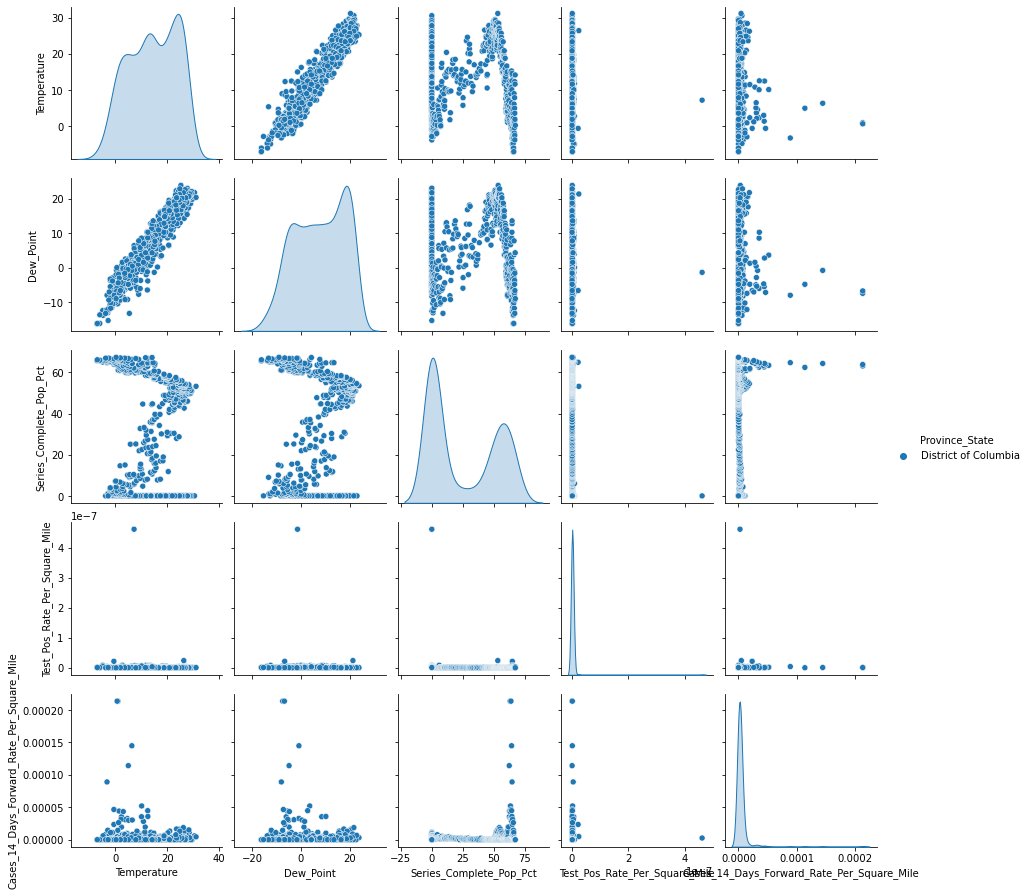

In [30]:
sns.pairplot(df_pp, hue = 'Province_State')

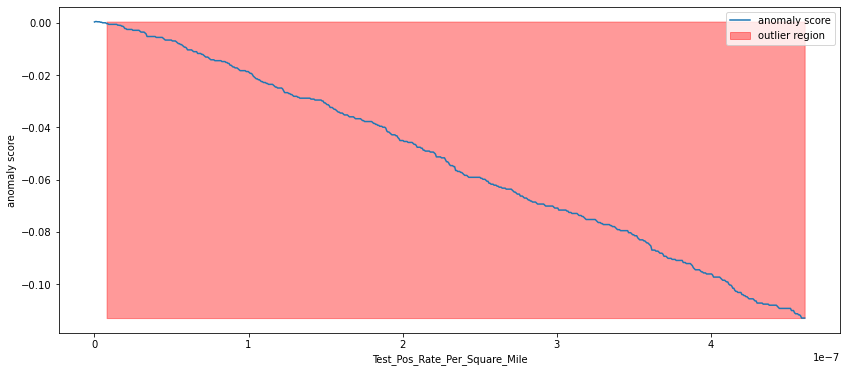

In [31]:
isolation_forest = IsolationForest(n_estimators=1000, contamination = 0.01, bootstrap = True, random_state = 42)

df = df_pp[['Test_Pos_Rate_Per_Square_Mile']]

isolation_forest.fit(df.values.reshape(-1, 1))

xx = np.linspace(df.min(), df.max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(14,6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Test_Pos_Rate_Per_Square_Mile')
plt.show()

In [32]:
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "Test_Pos_Rate_Per_Square_Mile", text = "Test_Pos_Rate_Per_Square_Mile")

In [33]:
md_granular[(md_granular['Province_State'] == 'District of Columbia') & (md_granular['Date_Block'] >= 20200412) & (md_granular['Date_Block'] <= 20200416)][['Last_Update', 'New_Tests', 'New_Cases', 'Test_Positivity', 'Total_Test_Results', 'Test_Pos_Rate_Per_Square_Mile']]

,Last_Update,New_Tests,New_Cases,Test_Positivity,Total_Test_Results,Test_Pos_Rate_Per_Square_Mile
22,2020-04-12 23:18:00,10640.0,97.0,0.009117,10640.0,2.115895e-10
23,2020-04-13 23:07:54,294.0,80.0,0.272109,10934.0,6.315485e-09
24,2020-04-14 23:33:31,584.0,103.0,0.176370,11518.0,4.093440e-09
25,2020-04-15 22:56:51,7.0,139.0,19.857143,11525.0,4.608725e-07
26,2020-04-16 23:30:51,625.0,153.0,0.244800,12150.0,5.681663e-09


A data oddity is identified here on 4-15-2020. Test positivity is impossibly high. A test positivity of 1 would be the highest it could go, as it implies all tests are returning COVID positive.

In [34]:
md_granular[(md_granular['Province_State'] == 'District of Columbia') & (md_granular['Date_Block'] >= 20210806) & (md_granular['Date_Block'] <= 20210816)][['Last_Update', 'New_Tests', 'New_Cases', 'Test_Positivity', 'Total_Test_Results', 'Test_Pos_Rate_Per_Square_Mile']]

,Last_Update,New_Tests,New_Cases,Test_Positivity,Total_Test_Results,Test_Pos_Rate_Per_Square_Mile
503,2021-08-07 04:21:30,4006.0,128.0,0.031952,1747398.0,7.415887e-10
504,2021-08-08 04:21:33,4700.0,0.0,0.000000,1752098.0,0.000000e+00
505,2021-08-09 04:21:24,0.0,0.0,0.017309,1752098.0,4.017314e-10
506,2021-08-10 04:21:27,0.0,486.0,0.017309,1752098.0,4.017314e-10
507,2021-08-11 04:21:58,5463.0,0.0,0.000000,1757561.0,0.000000e+00
508,2021-08-12 04:21:25,7337.0,264.0,0.035982,1764898.0,8.351211e-10
509,2021-08-13 04:21:24,147.0,152.0,1.034014,1765045.0,2.399884e-08
510,2021-08-14 04:21:25,6815.0,196.0,0.028760,1771860.0,6.675046e-10
511,2021-08-15 04:21:41,5143.0,0.0,0.000000,1777003.0,0.000000e+00
512,2021-08-16 04:21:31,0.0,0.0,0.164741,1777003.0,3.823543e-09


Here is appears that testing data and case data are shifted by one day. The days with zero new cases and zero tests are not lined up.

In [35]:
md_granular = md_granular.drop(['Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Data_Date', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio','Confirmed','Deaths'], axis = 1)
md_granular = md_granular.sort_values(by = ['FIPS', 'Date_Block'])

In [36]:
X_train = md_granular[(md_granular['Date_Block'] > 20200415) & (md_granular['Date_Block'] <= 20220126)]
X_validation = md_granular[(md_granular['Date_Block'] > 20220126) & (md_granular['Date_Block'] <= 20220127)]

In [37]:
def custom_isolation_forest(x, y, xmin, xmax, ymin, ymax):

    rng = np.random.RandomState(42)

    clf = IsolationForest(max_samples=50000, random_state=rng)
    clf.fit(X_train[[x, y]].fillna(0).to_numpy())
    y_pred_train = clf.predict(X_train[[x, y]].fillna(0).to_numpy())
    y_pred_test = clf.predict(X_validation[[x, y]].fillna(0).to_numpy())

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title(x + " vs " + y)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.xlabel(x)
    plt.ylabel(y)

    b1 = plt.scatter(X_train[[x, y]].fillna(0).to_numpy()[:, 0], X_train[[x, y]].fillna(0).to_numpy()[:, 1], c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_validation[[x, y]].fillna(0).to_numpy()[:, 0], X_validation[[x, y]].fillna(0).to_numpy()[:, 1], c="green", s=20, edgecolor="k")
    plt.axis("tight")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.legend(
        [b1, b2],
        ["training", "validation"],
        loc="upper left",
    )
    plt.show()

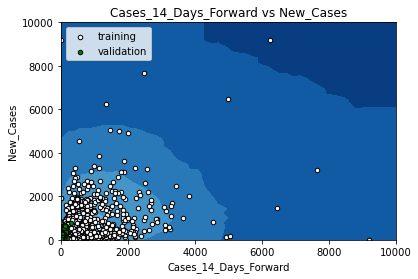

In [38]:
custom_isolation_forest(x = 'Cases_14_Days_Forward', y = 'New_Cases', xmin = -0.1, xmax = 10000, ymin = -0.1, ymax = 10000)

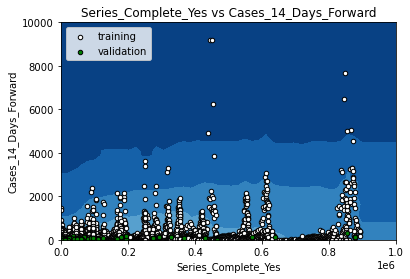

In [39]:
custom_isolation_forest(x = 'Series_Complete_Yes', y = 'Cases_14_Days_Forward', xmin = 0, xmax = 1000000, ymin = 0, ymax = 10000)

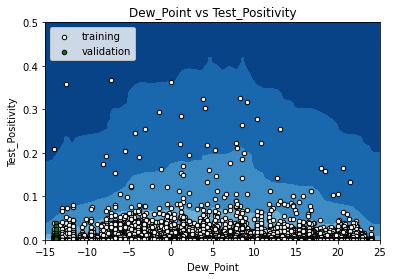

In [40]:
custom_isolation_forest(x = 'Dew_Point', y = 'Test_Positivity', xmin = -15, xmax = 25, ymin = 0, ymax = 0.5)

## Correct oddities in the data

Fixes that are needed:
1. Testing and case data appear shifted by one day. This is visible in late 2021 data when data is no longer reported on weekends and instead lumped into the following business day.
2. Data is generally reported daily. But in some cases data is not reported on weekends/holidays and data occurring across weekends/holidays are aggregated with the data of the following business day. Will need to create a feature which identifies days where data is not reported and another feature to identify those days where weekend data is aggregated with the following business day (E.g. so that the model knows to expect larger than "normal" numbers on Mondays because Monday includes Saturday and Sunday data).
3. Travel data has spikes down to zero to preserve anonymity. Will need to fix those datapoints, such as substitute with an average of nearby dates. 
4. Testing data has spikes up. Those will need to be corrected.
5. Similarly, test positivity looks erroneous in some situations, such as DC in April 2020. 
6. In some cases, fully vaccinated percentages drop. Unclear why that would happen. Perhaps people moving into the county who aren't vaccinated? Or adjustments for people who got vaccinated in a county but aren't residents of the county where they received the vaccine? Unclear how to fix or whether to fix.
7. Maryland testing data for most of December missing.

Re-load data, re-create basic features and fix data errors along the way

In [41]:
### case data ###
granular_covid_data = parallel_load()
granular_covid_data = granular_covid_data.sort_values(by = ['Province_State', 'FIPS', 'Date_Block'])
#################

### testing data ###
covid_data = pd.DataFrame()

path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports_us/*.csv"

for file in glob.glob(path):
    tmp = pd.read_csv(file)
    file_date = file[-14:-4] #this extracts the date from the filename
    
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5]))
    
    # handle different column names with the same testing data
    if 'People_Tested' in tmp.columns:
        tmp = tmp.rename(columns={"People_Tested": 'Total_Test_Results'})

    covid_data = pd.concat([covid_data,tmp])

covid_data = covid_data.sort_values(by = ['Province_State', 'Date_Block'])

covid_data = covid_data[['Province_State', 'Total_Test_Results', 'Date_Block']]

granular_covid_data = pd.merge(granular_covid_data, covid_data, on = ["Province_State", 'Date_Block'], how = 'left')

## fix for problem 1 
granular_covid_data['Total_Test_Results'] = granular_covid_data['Total_Test_Results'].shift(-1).fillna(0).clip(lower = 0)
####################



### vaccination data ###
vaxx_data = pd.read_csv("CDC/COVID-19_Vaccinations_in_the_United_States_County.csv")
vaxx_data = vaxx_data[['Date', 'FIPS', 'Series_Complete_Pop_Pct', 'Series_Complete_Yes', 'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct']]

vaxx_data['Date'] = pd.to_datetime(vaxx_data['Date'])
vaxx_data['Date_Block'] = vaxx_data['Date'].dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block
vaxx_data = vaxx_data[vaxx_data['FIPS'] != "UNK"] # drop rows where FIPS is unknown
vaxx_data['FIPS'] = vaxx_data['FIPS'].astype(int)
vaxx_data.drop(['Date'], axis = 1, inplace = True)

granular_covid_data = pd.merge(granular_covid_data, vaxx_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)
#######################


### land area ###
land_area = pd.read_excel("Census/LND01.xls")
land_area = land_area[['STCOU', 'LND110210D']]
land_area = land_area.rename(columns={"STCOU": 'FIPS', "LND110210D": 'Land_Area'})
granular_covid_data = pd.merge(granular_covid_data, land_area, on = ["FIPS"], how = 'left').fillna(0)
#################

### travel data ###
travel_data = pd.read_csv("DOT/Trips_by_Distance.csv")
travel_data['Date_Block'] = pd.to_datetime(travel_data['Date']).dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block

# keep only county-level data
travel_data = travel_data[travel_data['Level'] == 'County']
travel_data.drop(['Level', 'Date', 'State FIPS', 'State Postal Code', 'County Name', 'Row ID', 'Week', 'Month'], axis = 1, inplace = True)
travel_data = travel_data.rename(columns={'County FIPS': 'FIPS', 'Number of Trips <1': 'Number of Trips lt 1', 'Number of Trips >=500': 'Number of Trips gt 500'})

## fix for problem 3
# replace NaNs -- originally replaced with zeros -- with 5 day exponential moving average

travel_cols = ['Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'Number of Trips lt 1', 'Number of Trips 1-3',
       'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips gt 500']
for col in travel_cols:
    travel_data[col] = travel_data.groupby(['FIPS'])[col].fillna(travel_data[col].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean()))

granular_covid_data = pd.merge(granular_covid_data, travel_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)
########################


### weather data ###
weather_data = pd.read_csv("NOAA/Dulles_2020.csv")
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2021.csv")])
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2022.csv")])[['DATE', 'SOURCE', 'TMP', 'DEW', 'SLP']]  #Date, measurement source id, temperature, dewpoint, pressure 

weather_data['Data_Date'] = pd.to_datetime(weather_data['DATE'])
weather_data['Date_Block'] = weather_data['Data_Date'].dt.strftime('%Y%m%d').astype(int)

# retain data from one weather station.
weather_data = weather_data[weather_data['SOURCE']==4]

# convert tmp, dew and slp from the encoded format to usable data
weather_data['Temperature'] = -9999
weather_data['Dew_Point'] = -9999
weather_data['Pressure'] = -9999

for i in range(len(weather_data)):
    weather_data.iloc[i,7] = int(weather_data.iloc[i,2][:-2])/10 #temperature
    weather_data.iloc[i,8] = int(weather_data.iloc[i,3][:-2])/10 #dew point
    weather_data.iloc[i,9] = int(weather_data.iloc[i,4][:-2])/10 #pressure

# Drop rows with suspect pressure numbers
weather_data = weather_data[weather_data['Pressure'] < 2000] 

weather_data = weather_data.drop(['DATE','SOURCE', 'TMP', 'DEW', 'SLP', 'Data_Date'], axis = 1)
weather_data = weather_data.groupby('Date_Block').mean()
weather_data = weather_data.reset_index()

# merge weather data
granular_covid_data = pd.merge(granular_covid_data, weather_data, on = ['Date_Block'], how = 'left')

# fix nans in weather data
granular_covid_data['Temperature'] = granular_covid_data['Temperature'].fillna(granular_covid_data['Temperature'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)
granular_covid_data['Dew_Point'] = granular_covid_data['Dew_Point'].fillna(granular_covid_data['Dew_Point'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)
granular_covid_data['Pressure'] = granular_covid_data['Pressure'].fillna(granular_covid_data['Pressure'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)

###################

### basic features ###
# calculate new cases
granular_covid_data['New_Cases'] = granular_covid_data['Confirmed'].diff(periods = 1).fillna(0).clip(lower = 0)

# calculate new tests
### fix for problem 4
# if change in total tests exceeds a threshold amount, replace with NaN, then replace new tests with moving average
granular_covid_data.loc[(granular_covid_data['Total_Test_Results'].diff(periods = 1) / granular_covid_data['Total_Test_Results'] >= .1), 'Total_Test_Results'] = np.nan

granular_covid_data['New_Tests'] = granular_covid_data['Total_Test_Results'].diff(periods = 1)
granular_covid_data['New_Tests'] = granular_covid_data['New_Tests'].fillna(granular_covid_data['New_Tests'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)

## fix for problem 2, identifying days where data is not reported and identifying days where the data is aggregated to include weekend's data.
granular_covid_data['Is_Data_Reported'] = 1
granular_covid_data['Is_Data_Reported'] = np.where(
    ((granular_covid_data['New_Cases'] == 0.0) & (granular_covid_data['New_Tests'] == 0.0)), 0, 1)
granular_covid_data['Data_Lumped'] = granular_covid_data['Is_Data_Reported'].diff(periods = 1).fillna(0).clip(lower = 0)


## fix for problem 7
# The total number of tests performed between 12-05 and 12-26 is 798752
# Assume that an equal number of tests are performed each day. 
# not perfect but better than assume no tests occured. Zero tests or a large number of tests would impact Test_Positivity.

for dateblock in range(20211205,20211227):
    granular_covid_data.loc[(granular_covid_data['Province_State'] == 'Maryland') & (granular_covid_data['Date_Block']==dateblock), 'New_Tests'] = 798752//21



### Add population.
imputed_population = granular_covid_data[granular_covid_data['Date_Block'] == 20200529]
imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)

cols = ['Admin2', 'Province_State', 'Population']
tmp = imputed_population[cols]
granular_covid_data = pd.merge(granular_covid_data, tmp, on = ['Admin2', 'Province_State'], how = 'left')

granular_covid_data = granular_covid_data.dropna(subset=['Date_Block','FIPS', 'Population']).reset_index().drop(['index'], axis=1) #this is to drop the unclassified FIPS
granular_covid_data = granular_covid_data[granular_covid_data['Admin2'] != "Unassigned"] # drops unassigned counties (Delaware related)

# Add test positivity rate. Not perfect as this calculates county-level new cases divided by state-wide new tests. 
# So this is like a contribution to the state's positivity rate.
granular_covid_data['Test_Positivity'] = (granular_covid_data['New_Cases'] / granular_covid_data['New_Tests'])

#some dates have no new tests but positive new cases. this will cause inf
granular_covid_data.replace([np.inf], np.nan, inplace = True)

##### fix for problem 5
# for those days where test positivity exceeds 1, replace with NaN, then the below will replace NaNs with moving averages.
granular_covid_data.loc[(granular_covid_data['Test_Positivity'] >= 1), 'Test_Positivity'] = np.nan

# replace NaNs with 5 day exponential moving average
granular_covid_data['Test_Positivity'] = granular_covid_data.groupby(['FIPS'])['Test_Positivity'].fillna(granular_covid_data['Test_Positivity'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean()))

granular_covid_data['Infection_Rate_Per_Square_Mile'] = (granular_covid_data['New_Cases']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['One_Dose_Rate_Per_Square_Mile'] = (granular_covid_data['Administered_Dose1_Recip']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Full_Vaxx_Rate_Per_Square_Mile'] = (granular_covid_data['Series_Complete_Yes']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Test_Pos_Rate_Per_Square_Mile'] = (granular_covid_data['Test_Positivity']/granular_covid_data['Population'])/granular_covid_data['Land_Area']

granular_covid_data['Percent_People_Staying_Home'] = granular_covid_data['Population Staying at Home'] / (granular_covid_data['Population Staying at Home'] + granular_covid_data['Population Not Staying at Home'])


/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (36,45,57,62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (42,43,44,54,59,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-41-46e7e115e2d3>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)


### Check that the bugs are corrected

In [42]:
spaghetti_chart(state = "District of Columbia", counties = 'all', metric = "Test_Pos_Rate_Per_Square_Mile", text = "Test_Pos_Rate_Per_Square_Mile")

In [43]:
spaghetti_chart(state = "Maryland", counties = ['Montgomery'], metric = "New_Tests", text = "New Tests")

In [44]:
granular_covid_data[(granular_covid_data['Province_State'] == 'District of Columbia') & (granular_covid_data['Date_Block'] >= 20210806) & (granular_covid_data['Date_Block'] <= 20210816)][['Last_Update', 'New_Tests', 'New_Cases', 'Test_Positivity', 'Total_Test_Results', 'Test_Pos_Rate_Per_Square_Mile','Is_Data_Reported', 'Data_Lumped']]

,Last_Update,New_Tests,New_Cases,Test_Positivity,Total_Test_Results,Test_Pos_Rate_Per_Square_Mile,Is_Data_Reported,Data_Lumped
214468,2021-08-07 04:21:30,4700.0,128.0,0.027234,1752098.0,6.320860e-10,1,0.0
214469,2021-08-08 04:21:33,0.0,0.0,0.029780,1752098.0,6.911658e-10,0,0.0
214470,2021-08-09 04:21:24,0.0,0.0,0.029780,1752098.0,6.911658e-10,0,0.0
214471,2021-08-10 04:21:27,5463.0,486.0,0.088962,1757561.0,2.064758e-09,1,1.0
214472,2021-08-11 04:21:58,7337.0,0.0,0.000000,1764898.0,0.000000e+00,1,0.0
214473,2021-08-12 04:21:25,147.0,264.0,0.040741,1765045.0,9.455744e-10,1,0.0
214474,2021-08-13 04:21:24,6815.0,152.0,0.022304,1771860.0,5.176566e-10,1,0.0
214475,2021-08-14 04:21:25,5143.0,196.0,0.038110,1777003.0,8.845118e-10,1,0.0
214476,2021-08-15 04:21:41,0.0,0.0,0.034596,1777003.0,8.029580e-10,0,0.0
214477,2021-08-16 04:21:31,0.0,0.0,0.034596,1777003.0,8.029580e-10,0,0.0
